The work presented in this notebook is based on the paper:

`Depth optimization of quantum search algorithms beyond Grover’s algorithm` https://arxiv.org/abs/1908.04171 .

# Imports

In [1]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile, execute
from qiskit.circuit.library import MCMT
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Provider and backends

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Depth optimization

We live in the era of noisy intermediate scale quantum (NISQ) computers. One consequence of this noise is that Grover's Algorithm for n=4 fails for (at least most) of current quantum computers. In this notebook I am to demonstrate this failure, and then apply the depth optimization of the mentioned paper to obtain a better result.

## Standard Grover algorithm for n=3 in ibmq_manila 

First off, let's build all relevant components of the algorithm.

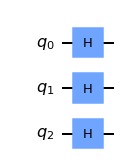

In [4]:
def init_circ(n_qubits):
    qr = QuantumRegister(n_qubits, 'q')
    init = QuantumCircuit(qr)
    init.h(qr)
    return init

init3 = init_circ(3)
init3.draw()

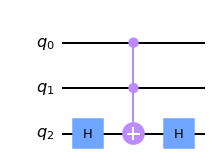

In [5]:
def oracle_circ(n_qubits):
    qr = QuantumRegister(n_qubits, 'q')
    oracle = QuantumCircuit(qr)
    oracle.h(-1)
    oracle.compose(MCMT('x', n_qubits-1, 1), inplace=True)
    oracle.h(-1)
    return oracle

oracle3 = oracle_circ(3)
oracle3.draw()

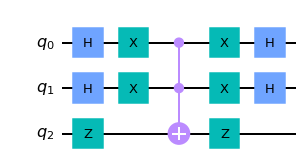

In [6]:
def diffusion_circ(n_qubits):
    qr = QuantumRegister(n_qubits, 'q')
    diffusion = QuantumCircuit(qr)
    diffusion.h(qr[:-1])
    diffusion.x(qr[:-1])
    diffusion.z(-1)
    diffusion.compose(MCMT('x', n_qubits-1, 1), inplace=True)
    diffusion.z(-1)
    diffusion.x(qr[:-1])
    diffusion.h(qr[:-1])
    return diffusion

diffusion3 = diffusion_circ(3)
diffusion3.draw()

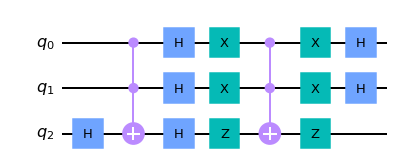

In [7]:
grover3 = QuantumCircuit(3)
grover3.compose(oracle3, inplace=True)
grover3.compose(diffusion3, inplace=True)
grover3.draw()

In [8]:
def grover_circs(init, grover):
    circ_lst = []
    circ = QuantumCircuit(init.num_qubits)

    circ.compose(init, inplace=True)
    circ_temp = deepcopy(circ)
    circ_temp.measure_all()
    circ_lst.append(circ_temp)

    for i in range(10):
        circ.compose(grover, inplace=True)
        circ_temp = deepcopy(circ)
        circ_temp.measure_all()
        circ_lst.append(circ_temp)
    return circ_lst

circ_lst3 = grover_circs(init3, grover3)

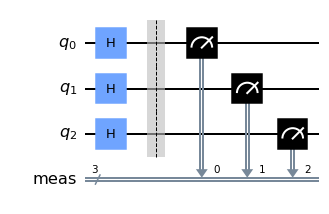

In [9]:
circ_lst3[0].draw()

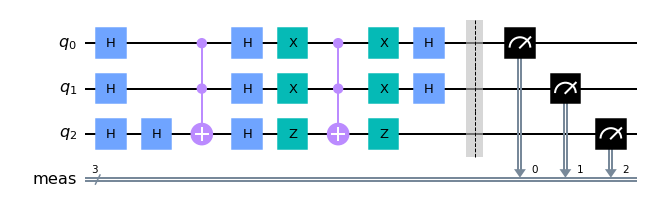

In [10]:
circ_lst3[1].draw()

In [11]:
def success_probabilities(counts, target):
    probs = []
    shots = sum(counts[0].values())
    for c in counts:
        probs.append(c.get(target, 0)/shots)
    return probs

Another relevant measure of success in quantum search algorithms concerns the selectivity of the target state, i.e. if the target state is unknown, how well can one tell that a particular basis state is the target state. In the paper `Prospect of using Grovers search in the noisy intermediate scale quantum computer era` (https://arxiv.org/abs/2006.10037), a selectivity measure is define as:

$$ S=10 \log _{10}\left(P_{t} / P_{h n}\right) $$

where $P_{t}$ is the probability of the target state, and $P_{h n}$ is the probability of the highest noise signal.

In [12]:
def selectivity(counts_lst, target):
    counts_lst = deepcopy(counts_lst)
    selec = []
    shots = sum(counts_lst[0].values())
    for c in counts_lst:
        p_t = c.get(target, 0)/shots
        c.pop(target)
        p_hn = max(c.values())/shots
        selec.append(10*np.log10(p_t/p_hn))
    return selec

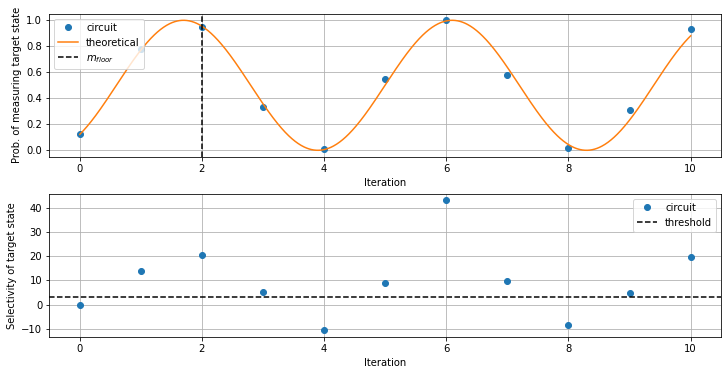

In [13]:
def plot_analysis(probs, selec):
    a = probs[0]
    theta = np.arcsin(np.sqrt(a))
    m = np.arange(len(probs))
    ms = np.linspace(m[0], m[-1], 1000)
    
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (10, 5), constrained_layout=True)
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Prob. of measuring target state')
    axs[0].plot(probs, 'o', label='circuit')
    axs[0].plot(ms, np.sin((2*ms+1)*theta)**2, label='theoretical')
    axs[0].axvline(x=np.floor(np.pi/(4*theta)), c='k', ls='--', label=r'$m_{floor}$')
    axs[0].legend()
    axs[0].grid()
    
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Selectivity of target state')
    axs[1].plot(selec, 'o', label='circuit')
    axs[1].axhline(y=3, c='k', ls='--', label='threshold')
    axs[1].legend()
    axs[1].grid()
    plt.plot()

job = execute(circ_lst3, backend=backend_sim, shots=20000)
counts = job.result().get_counts()
probs = success_probabilities(counts, '111')
selec = selectivity(counts, '111')
plot_analysis(probs, selec)

Now let's run this on an actual quantum computer.

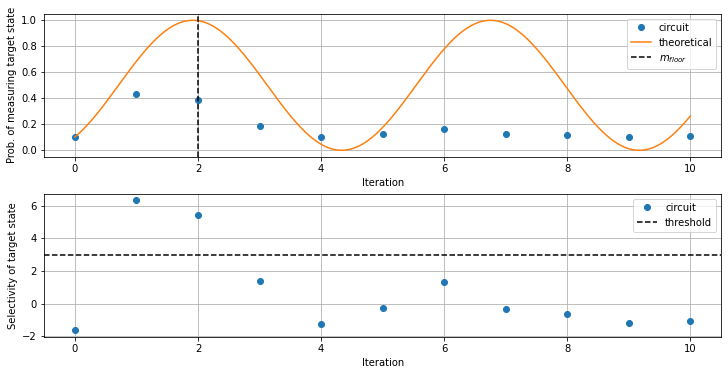

In [14]:
# job = execute(circ_lst3, backend=backend_qc, shots=20000) # 61cca1db3b5b840335104242
# job_monitor(job)
job = backend_qc.retrieve_job('61cca1db3b5b840335104242')
counts = job.result().get_counts()
probs = success_probabilities(counts, '111')
selec = selectivity(counts, '111')
plot_analysis(probs, selec)

## Standard Grover algorithm for n=4 in ibmq_manila 

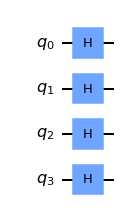

In [15]:
init4 = init_circ(4)
init4.draw()

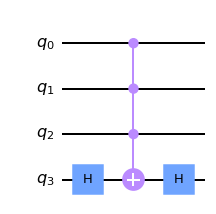

In [16]:
oracle4 = oracle_circ(4)
oracle4.draw()

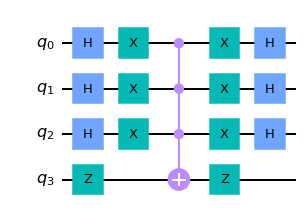

In [17]:
diffusion4 = diffusion_circ(4)
diffusion4.draw()

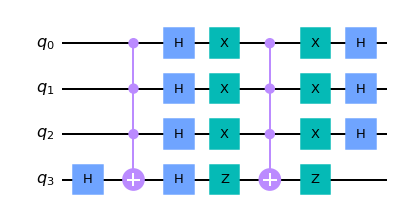

In [18]:
grover4 = QuantumCircuit(4)
grover4.compose(oracle4, inplace=True)
grover4.compose(diffusion4, inplace=True)
grover4.draw()

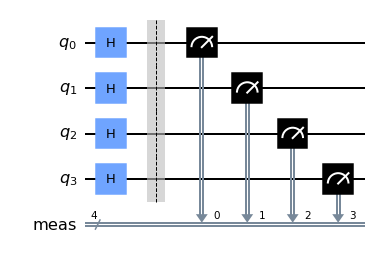

In [19]:
circ_lst4 = grover_circs(init4, grover4)
circ_lst4[0].draw()

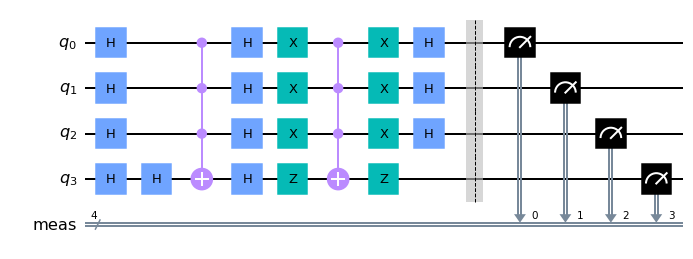

In [20]:
circ_lst4[1].draw()

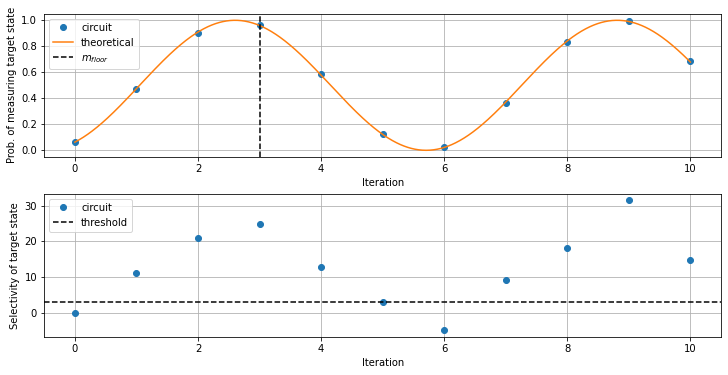

In [21]:
job = execute(circ_lst4, backend=backend_sim, shots=20000)
counts = job.result().get_counts()
probs = success_probabilities(counts, '1111')
selec = selectivity(counts, '1111')
plot_analysis(probs, selec)

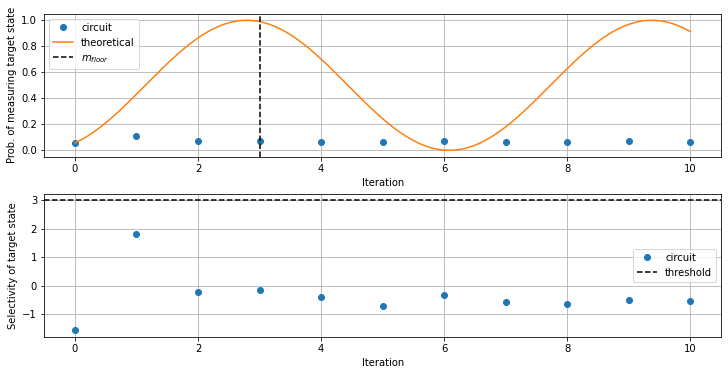

In [22]:
# job = execute(circ_lst4, backend=backend_qc, shots=20000) # 61ccaa6ebf935f07ef647ba9
# job_monitor(job)
# transpiled_circs = transpile(circ_lst4, backend=backend_qc, optimization_level=3) 
# job = execute(transpiled_circs, backend=backend_qc, shots=20000) # 61ccb06e2ac6ddd12e4ccb31 (optimized transpile)
# job_monitor(job)
job = backend_qc.retrieve_job('61ccb06e2ac6ddd12e4ccb31')
counts = job.result().get_counts()
probs = success_probabilities(counts, '1111')
selec = selectivity(counts, '1111')
plot_analysis(probs, selec)

## Optimization

According to this paper, applying the diffusion operator to only some of the qubits (local diffusion operator) may present a significant boost in the success probability, since it uses a Toffoli gate with less control bits, which means it's more shallow that the global diffusion operator. It's stated that for n=4 the optimal sequence of this optimized method is to first do a grover iteration with a diffusion of only 3 of the qubits, and then a full grover iteration. Let's test this.

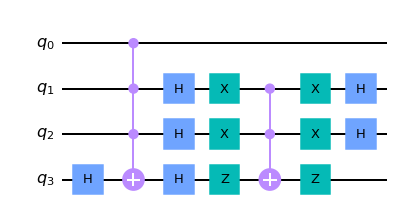

In [23]:
grover4_local = QuantumCircuit(4)
grover4_local.compose(oracle4, inplace=True)
grover4_local.compose(diffusion_circ(3), [1, 2, 3], inplace=True)
grover4_local.draw()

In [24]:
circ_lst = []
circ = QuantumCircuit(init4.num_qubits)

circ.compose(init4, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

# first iteration
circ.compose(grover4_local, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

# second iteration
circ.compose(grover4, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

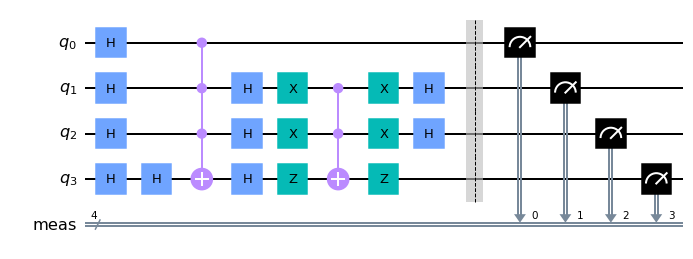

In [25]:
circ_lst[1].draw()

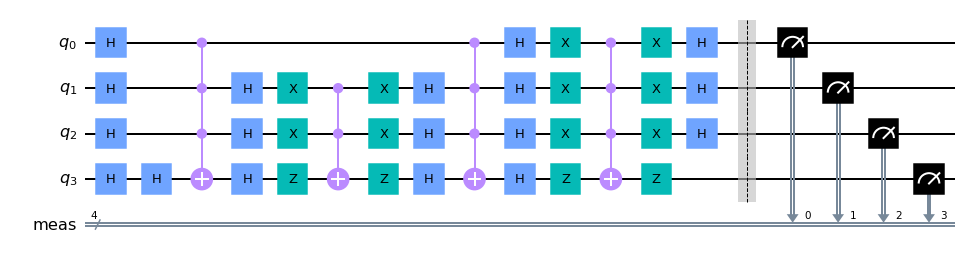

In [26]:
circ_lst[2].draw()

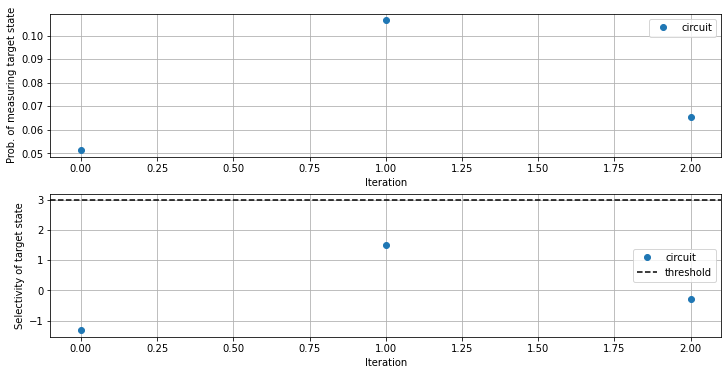

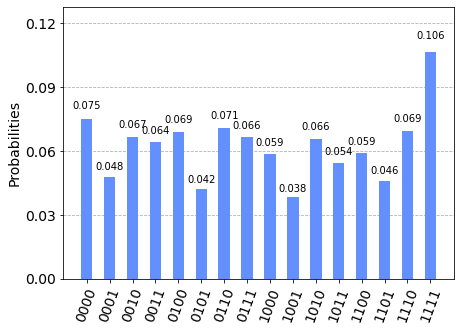

In [46]:
# job = execute(circ_lst, backend=backend_qc, shots=20000) # 61cda35a049a23ed99d1e643
# transpiled_circ_lst = transpile(circ_lst, backend=backend_qc)
# job = execute(transpiled_circ_lst, backend=backend_qc, shots=20000) # 61cda35dd6d3bc9fafd3030f
# print(job.job_id())
# transpiled_circ_lst = transpile(circ_lst, backend=backend_qc, optimization_level=3)
# job = execute(transpiled_circ_lst, backend=backend_qc, shots=20000) # 61cda3610635195e17a7f6d6 -O3
# print(job.job_id())
# job_monitor(job)

job = backend_qc.retrieve_job('61cda35dd6d3bc9fafd3030f')
counts = job.result().get_counts()
probs = success_probabilities(counts, '1111')
selec = selectivity(counts, '1111')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (10, 5), constrained_layout=True)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Prob. of measuring target state')
axs[0].plot(probs, 'o', label='circuit')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Selectivity of target state')
axs[1].plot(selec, 'o', label='circuit')
axs[1].axhline(y=3, c='k', ls='--', label='threshold')
axs[1].legend()
axs[1].grid()
plt.show()

plot_histogram(counts[1])

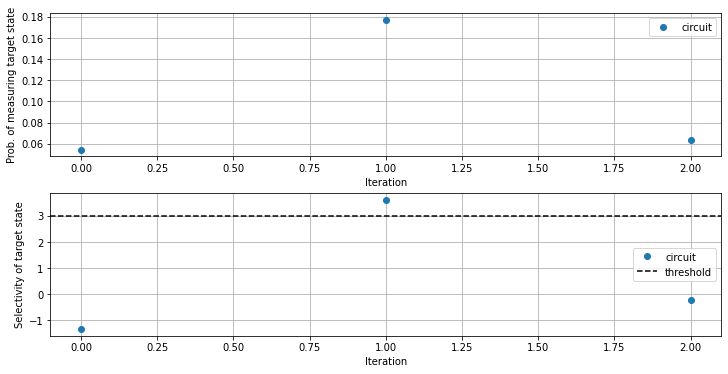

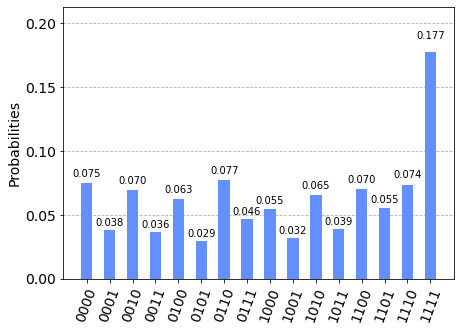

In [45]:
job = backend_qc.retrieve_job('61cda3610635195e17a7f6d6') # O3
counts = job.result().get_counts()
probs = success_probabilities(counts, '1111')
selec = selectivity(counts, '1111')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (10, 5), constrained_layout=True)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Prob. of measuring target state')
axs[0].plot(probs, 'o', label='circuit')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Selectivity of target state')
axs[1].plot(selec, 'o', label='circuit')
axs[1].axhline(y=3, c='k', ls='--', label='threshold')
axs[1].legend()
axs[1].grid()
plt.show()

plot_histogram(counts[1])